# Optimization methods for Optimal Transport

## Maksim Nekrashevich


In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
import ot
import pandas as pd
from scipy.special import logsumexp
from scipy.stats import dirichlet

## Kantorovich formulation of OT

$\mu$, $\nu$ - pobability measures defined on $X$, $Y$ respectively. (In general, $X$, $Y$ - continuous, but we assume them to be discrete.)

$\Pi(\mu, \nu)$ - the space of all couplings of $\mu$, $\nu$, i.e., measures $\pi$ on $X \times Y$, such that $\int_Y d\pi = d\mu$, $\int_X d\pi = d\nu$.

The relaxed OT problem is defined as follows:

$$
\operatorname{OT}(\mu, \nu) = \inf_{\pi \in \Pi(\mu,\nu)}\int\limits_{X \times Y} c(x, y)d\pi(x, y)
$$



If $X$ and $Y$ are discrete, the distributions $\mu, \nu$ can be described by their probability vectors $p \in S_1(m)$ and $q \in S_1(n)$.
The cost $c$ can now be represented by a matrix $C_{ij}$ as well as the measures $\pi$. So the discrete OT problem has the following form:

$$
\operatorname{OT}(p, q) = \min_{\pi \in U(p, q)}\langle C, \pi\rangle
$$

## Initialize distributions

In [2]:
def get_distribution(num_atoms: int) -> np.ndarray:
    return dirichlet(np.ones(num_atoms)).rvs().flatten()

In [40]:
np.random.seed(0)

n = m = 128
p = get_distribution(n)
q = get_distribution(m)
C = np.random.rand(n, m)

In [41]:
pi_true = ot.lp.emd(p, q, C)
np.sum(pi_true * C)

0.022164624400878078

### Primal LP problem

<!-- \begin{align*}
& \sum_{i,j} C_{ij}\pi_{ij} \to \min_{\pi_{ij}} \\
\text{s.t.} & \forall i \: \sum_j \pi_{ij} = p_i \\
& \forall j \: \sum_i \pi_{ij} = q_j 
\end{align*} -->

\begin{align*}
& \langle C, \pi \rangle \to \min_{\pi} \\
\text{s.t.} \quad & \pi \geqslant 0 \\
& \pi \mathbf{1}_n = p \\
& \mathbf{1}_m^T \pi = q
\end{align*}

In [42]:
pi = cp.Variable((n, m))

primal_lp = cp.Problem(
    cp.Minimize(cp.sum(cp.multiply(C, pi))),
    [cp.sum(pi, axis=0) == q, cp.sum(pi, axis=1) == p, pi >= 0]
)
primal_lp.solve()

0.022164624396027326

### Dual LP problem

\begin{align*}
& \langle p, f \rangle + \langle q, g \rangle \to \max_{f, g} \\
\text{s.t.} & \forall i, j \: f_i + g_j \leqslant C_{ij}
\end{align*}

In [43]:
f = cp.Variable(n)
g = cp.Variable(m)

dual_lp = cp.Problem(
    cp.Maximize(p @ f + q @ g),
    [cp.reshape(f, (n, 1)) + cp.reshape(g, (1, m)) <= C]
)

dual_lp.solve()

0.022164624395781693

## Entropy-regularized OT

**Motivation:** Exact solution is computationally intensive.

**Idea:** Find a *"close-enough"* solution, i.e. $\tilde{\pi}$ s.t. $\langle C,\tilde{\pi}\rangle - \langle C,\pi^*\rangle \leqslant \varepsilon$.

$$
\operatorname{OT_\gamma}(p, q) = \min_{\pi \in U(p, q)} \langle C, \pi\rangle + \gamma H(\pi) \text{, where } H(\pi) = \langle \pi,\log\pi\rangle
$$

This problem is $\gamma$-strongly-convex on $S_1(n)$ in $\ell^1$-norm and therefore has a unique solution.

In [44]:
def get_B(C: np.ndarray, gamma: float):
    def func(u: np.ndarray, v: np.ndarray) -> np.ndarray:
        return np.exp(u[:, None] + v[None] - (C / gamma))
    return func

In [45]:
class OTAlgorithm:
    pi: np.ndarray

    def __init__(self, p: np.ndarray, q: np.ndarray,
                 C: np.ndarray,  gamma: float) -> None:
        assert np.all(p > 0) and np.isclose(p.sum(), 1)
        assert np.all(q > 0) and np.isclose(q.sum(), 1)
        assert np.all(C > 0)
        assert gamma > 0
        self.p = p
        self.q = q
        self.C = C
        self.gamma = gamma

    def step(self):
        raise NotImplementedError()

def run_algorithm(algorithm: OTAlgorithm, num_steps: int) -> pd.DataFrame:
    history = []
    for i in range(num_steps):
        algorithm.step()
        history.append({
            "step": i,
            "cost": np.sum(algorithm.pi * algorithm.C),
            "residual_p": np.linalg.norm(algorithm.p - algorithm.pi.sum(axis=1), ord=1),
            "residual_q": np.linalg.norm(algorithm.q - algorithm.pi.sum(axis=0), ord=1)
        })
    return pd.DataFrame(history).set_index("step")


![Scheme for Sinkhorn algorithm](./sinkhorn_algorithm.png)

In [46]:
class Sinkhorn(OTAlgorithm):
    def __init__(self, p: np.ndarray, q: np.ndarray,
                 C: np.ndarray,  gamma: float) -> None:
        super().__init__(p, q, C, gamma)
        self.u = np.zeros_like(p)
        self.v = np.zeros_like(q)
        self.B = get_B(self.C, self.gamma)

    @property
    def pi(self) -> np.ndarray:
        B = self.B(self.u, self.v)
        return B / B.sum()

    def step(self):
        self.u = -logsumexp(self.v[:, None] - self.C.T / self.gamma, b=1/self.p, axis=0)
        self.v = -logsumexp(self.u[:, None] - self.C / self.gamma, b=1/self.q, axis=0)

,cost,residual_p,residual_q
step,,,
199,0.025079,4.302628e-12,4.951145e-16


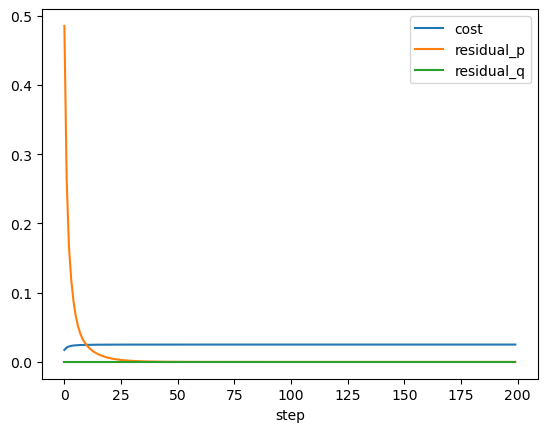

In [76]:
sinkhorn = Sinkhorn(p, q, C, .01)
sinkhorn_history = run_algorithm(sinkhorn, 200)
sinkhorn_history.plot()
sinkhorn_history.tail(1)

![Scheme for KL projection](./kl_projection.png)
![KL projection step](./kl_projecion_step.png)

In [48]:
class KLProjection(OTAlgorithm):
    def __init__(self, p: np.ndarray, q: np.ndarray,
                 C: np.ndarray,  gamma: float) -> None:
        super().__init__(p, q, C, gamma)
        self.pi = np.exp(-C / gamma)

    def step(self):
        self.pi *= (self.q / self.pi.sum(0))[None]
        self.pi *= (self.p / self.pi.sum(1))[:, None]

,cost,residual_p,residual_q
step,,,
199,0.025079,1.024571e-16,4.581555e-12


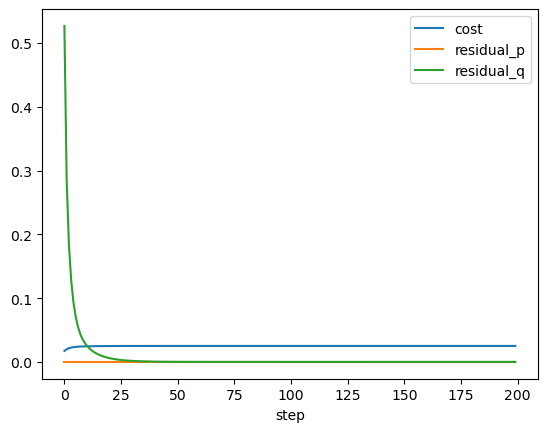

In [75]:
kl_projection = KLProjection(p, q, C, .01)
kl_projection_history = run_algorithm(kl_projection, 200)
kl_projection_history.plot()
kl_projection_history.tail(1)

## Advanced algorithms

![Greenkhorn Algorithm](./greeenkhorn.png)

In [107]:
class Greenkhorn(OTAlgorithm):
    def __init__(self, p: np.ndarray, q: np.ndarray, C: np.ndarray, gamma: float) -> None:
        super().__init__(p, q, C, gamma)
        self.K = np.exp(-C / gamma)
        self.u = np.ones(p.shape[0]) / p.shape[0]
        self.v = np.ones(q.shape[0]) / q.shape[0]

    @property
    def pi(self):
        return self.u[:, None] * self.K * self.v[None]

    def step(self):
        res_p = np.abs(self.pi.sum(1) - self.p)
        res_q = np.abs(self.pi.sum(0) - self.q)
        i = np.argmax(res_p)
        j = np.argmax(res_q)
        if res_p.max() > res_q.max():
            self.u[i] = self.p[i] / (self.K[i] @ self.v)
        else:
            self.v[j] = self.q[j] / (self.u @ self.K[:, j])

,cost,residual_p,residual_q
step,,,
1999,0.058004,4.226426e-07,4.378877e-07


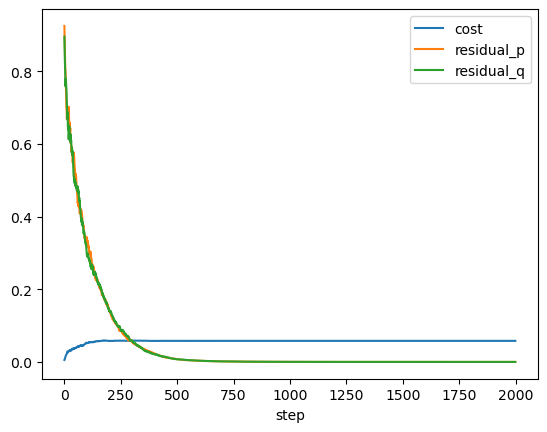

In [108]:
greenkhorn = Greenkhorn(p, q, C, .05)
greenkhorn_history = run_algorithm(greenkhorn, 2000)
greenkhorn_history.plot()
greenkhorn_history.tail(1)

<!-- ![PDAAM](./pdaam.png) -->
<img src="./pdaam.png" alt="PDAAM" width="70%"/>

In [85]:
from scipy.optimize import minimize_scalar

class Phi:
    def __init__(self, p: np.ndarray, q: np.ndarray, C: np.ndarray, gamma: float) -> None:
        self.mu = np.concatenate([p, q])
        self.C = C
        self.gamma = gamma

    def _get_B(self, eta: np.ndarray) -> np.ndarray:
        u, v = np.split(eta, 2)
        return np.exp(u[:, None] + v[None] - (self.C / self.gamma))

    def __call__(self, eta: np.ndarray) -> float:
        u, v = np.split(eta, 2)
        return self.gamma * logsumexp(u[:, None] + v[None] - (self.C / self.gamma)) - eta @ self.mu

    def grad(self, eta: np.ndarray) -> np.ndarray:
        B = self._get_B(eta)
        return np.concatenate([B.sum(1), B.sum(0)]) / B.sum() - self.mu

class PDAAM(OTAlgorithm):
    def __init__(self, p: np.ndarray, q: np.ndarray,
                 C: np.ndarray,  gamma: float) -> None:
        super().__init__(p, q, C, gamma)
        self.functional = Phi(p, q, C, gamma)
        self.A = self.a = 0
        self.zeta = self.eta = np.zeros_like(self.functional.mu)
        self.dim = self.p.shape[0]

    def _f(self, t: float) -> float:
        return self.functional(self.eta + t * (self.zeta - self.eta))

    def step(self):
        beta = minimize_scalar(self._f, bounds=(0, 1), method="bounded").x
        mu = beta * self.zeta - (1 - beta) * self.eta

        u, v = np.split(mu, 2)
        grad_u, grad_v = np.split(self.functional.grad(mu), 2)
        if np.linalg.norm(grad_u) > np.linalg.norm(grad_v):
            self.eta[:self.dim] = -logsumexp(v[:, None] - self.C.T / self.gamma, b=1/self.p, axis=0)
        else:
            self.eta[self.dim:] = -logsumexp(u[:, None] - self.C / self.gamma, b=1/self.q, axis=0)
        print(self.eta)

In [67]:
def round(pi, p, q):
    P = np.minimum(p / pi.sum(1), 1)[:, None]
    Q = np.minimum(q / pi.sum(0), 1)[None]
    F = P * pi * Q
    e_p = p - F.sum(1)
    e_q = q - F.sum(0)

    return F + np.outer(e_p, e_q) / np.abs(e_p).sum()

def approximate_sinkhorn(C: np.ndarray, p: np.ndarray, q: np.ndarray, epsilon: float):
    assert p.shape == q.shape
    n = p.shape[0]
    gamma = 1 / (4 * np.log(n))
    epsilon /= 8 * C.max()

    p_hat = (1 - epsilon / 8) * (p + epsilon / (8 * n))
    q_hat = (1 - epsilon / 8) * (q + epsilon / (8 * n))

    sinkhorn = Sinkhorn(p_hat, q_hat, C, gamma)

    for _ in range(2000):
        sinkhorn.step()
        residual_p = np.linalg.norm(p_hat - sinkhorn.pi.sum(axis=1), ord=1)
        residual_q = np.linalg.norm(q_hat - sinkhorn.pi.sum(axis=0), ord=1)
        if residual_p + residual_q <= epsilon / 2:
            break
    return round(sinkhorn.pi, p, q)